In [1]:
from keras.layers import Input, Dense,Dropout, Flatten,Lambda
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split as tts
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.utils import np_utils,plot_model
from keras.layers.convolutional import Convolution2D,MaxPooling2D,Conv2D
from keras import backend as K
from keras.losses import categorical_hinge,categorical_crossentropy
import tensorflow as tf
#from tensorflow.layers import flatten,batch_normialization as batch_norm

Using TensorFlow backend.
/home/slcf/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def corrupt(x,scale=0.5, rep =1, noise_type = 'gaussian'):
    x_rep = np.repeat(x,rep,axis=0)
    if noise_type == 'gaussian':
        noise = np.random.normal(size = x_rep.shape)
        x_crr = x_rep+scale*noise
    elif noise_type =='corruption':
        noise = np.random.binomial(1,1-scale,size = x_rep.shape)
        x_crr = x_rep * noise
    elif noise_type =='peppSalt':
        noise = np.random.choice([-1,0,1],size = x_rep.shape,
                                 p = [scale/2,1-scale,scale/2])
        x_crr = x_rep + noise
    return np.clip(x_rep,0.0,1.0), np.clip(x_crr,0.0,1.0)

In [8]:
xtrain_o,xtrain_n = corrupt(xtrain,scale = 0.3)
n=10
plt.figure(figsize = (20,4))
for i in range(n):
    # Display Original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(xtrain_o[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax .get_yaxis().set_visible(False)
    
    # Display Reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(xtrain_n[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

NameError: name 'xtrain' is not defined

In [9]:
dims = [784,1024,2048]
input_img = Input(shape=(dims[0],))
encoded = input_img
for idx,dim in enumerate(dims[1:]):
    encoded = Dense(dim,activation = 'elu')(encoded)
decoded = encoded
for idx, dim in enumerate(dims[:-1][::-1]):
    if idx < len(dims)-2:
        decoded = Dense(dim,activation='elu')(decoded)
    else:
        decoded = Dense(dim,activation='sigmoid')(decoded)
encoder = Model(input_img, encoded)
autoencoder = Model(input_img,decoded)
input_z = Input(shape=(dims[-1],))
decoder_layers = autoencoder.layers[len(dims):]
z_decoded = input_z
for lyr in decoder_layers:
    z_decoded = lyr(z_decoded)
decoder = Model(input_z,z_decoded)

In [10]:
print(z_decoded)

Tensor("dense_4_1/Sigmoid:0", shape=(?, 784), dtype=float32)


In [11]:
autoencoder.compile(optimizer = 'adadelta',loss='binary_crossentropy')

In [2]:
from keras.datasets import fashion_mnist as mnist
import numpy as np
(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
## Make the input image flat
n_features = np.prod(x_train.shape[1:])
xtrain = x_train.reshape((len(x_train),n_features))
xtest = x_test.reshape((len(x_test),n_features))

In [14]:
## Generate noised images
noise_scale = 0.3
xtrain_o,xtrain_n = corrupt(xtrain,scale = noise_scale)

In [15]:
# Split training and validation datasets
xtrain_t = np.concatenate([xtrain_o,xtrain_n],axis =1)
print(xtrain_t.shape)
dmm = np.ones(shape = (len(xtrain_t),))
xtr,xval,_,_ = tts(xtrain_t,dmm,test_size = 0.3)
xtr_o = xtr[:,:n_features]
xtr_n = xtr[:,n_features:]
xval_o = xval[:,:n_features]
xval_n = xval[:,n_features:]

(60000, 1568)


In [16]:
## Training the model
print("noise_scale: ",noise_scale)
autoencoder.fit(xtr_n,xtr_o,
               epochs = 50,
               batch_size = 128,
               shuffle=True,
               validation_data=(xval_n,xval_o),
               callbacks = [TensorBoard(log_dir = '../logs/mnist_denseDAE', histogram_freq=0,write_graph=False)]
                )

noise_scale:  0.3
Train on 42000 samples, validate on 18000 samples
Epoch 1/50
42000/42000 [==============================] - 4s 94us/step - loss: 0.2403 - val_loss: 0.1891
Epoch 2/50
42000/42000 [==============================] - 4s 87us/step - loss: 0.1645 - val_loss: 0.1519
Epoch 3/50
42000/42000 [==============================] - 4s 87us/step - loss: 0.1392 - val_loss: 0.1341
Epoch 4/50
42000/42000 [==============================] - 4s 88us/step - loss: 0.1252 - val_loss: 0.1240
Epoch 5/50
42000/42000 [==============================] - 4s 84us/step - loss: 0.1167 - val_loss: 0.1154
Epoch 6/50
42000/42000 [==============================] - 3s 82us/step - loss: 0.1108 - val_loss: 0.1111
Epoch 7/50
42000/42000 [==============================] - 3s 82us/step - loss: 0.1066 - val_loss: 0.1094
Epoch 8/50
42000/42000 [==============================] - 3s 82us/step - loss: 0.1034 - val_loss: 0.1062
Epoch 9/50
42000/42000 [==============================] - 3s 81us/step - loss: 0.1009 - val_

In [5]:
xtest_o,xtest_n = corrupt(xtest,scale =0.3)
decoded_imgs = autoencoder.predict(xtest_n)

n=10
plt.figure(figsize = (20,4))
for i in range(n):
    # Display Original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(xtest_n[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax .get_yaxis().set_visible(False)
    
    # Display Reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

NameError: name 'autoencoder' is not defined

# CNN Classifier

In [6]:
### Construct Classifier
X_train = xtrain.reshape(xtrain.shape[0],28,28,1)
Y_train = np_utils.to_categorical(y_train)
X_test = xtest.reshape(xtest.shape[0],28,28,1)
Y_test = np_utils.to_categorical(y_test)
#Y_test = y_test
## in this example, we used sparse cross entropy loss!
num_classes = 10
Xtr, Xval, Ytr, Yval = tts(X_train,Y_train,test_size = 0.3)
#Xtr, Xval, Ytr, Yval = tts(Xtr,Ytr,test_size = 0.3)

In [7]:
print(Ytr.shape)

(42000, 10)


In [8]:
def cnn_model_explicit(x,train_mode = True):
    
    with tf.variable_scope("CLF",reuse = tf.AUTO_REUSE) as vs:
        conv1 = tf.layers.conv2d(inputs = x, filters=32,
                            kernel_size=[5,5], padding='same',
                            activation= tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size = [2,2],
                                   strides = 2)
        conv2 = tf.layers.conv2d(inputs = pool1,
                            filters = 64, kernel_size = [5,5],
                            padding = 'same', activation = tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs = conv2, pool_size = [2,2],
                                    strides = 2)
        pool2_flat = tf.layers.flatten(pool2)
        dense = tf.layers.dense(inputs = pool2_flat,units=1024, 
                            activation = tf.nn.relu)
        dropout = tf.layers.dropout(inputs=dense, rate=0.4, 
                                training =train_mode)
        logits = tf.layers.dense(inputs=dropout, units = 10)
    variables = tf.contrib.framework.get_variables(vs)
    return logits, variables

In [26]:
class Mnist_CNN:
    def __init__(self,trainX,trainY,num_batch=128,num_epoch=10,lr = 1e-3,val_ratio = 0.3):
        self.trainX = trainX
        self.trainY = trainY
        self.val_ratio = val_ratio
        self.num_data = len(trainY)
        self.num_batch = num_batch
        self.num_epoch = num_epoch
        self.lr = lr
        self.build_model()
        self.sess = tf.Session()
        self.saver = tf.train.Saver()
        
    def build_model(self):
        self.input_imgs = tf.placeholder(tf.float32,shape=(None,28,28,1))
        self.labels = tf.placeholder(tf.int32,shape=(None,10))
        self.eval_imgs = tf.placeholder(tf.float32,shape=(None,28,28,1))
        self.labels_eval = tf.placeholder(tf.int32,shape=(None,10))
        self.logits, self.clf_variables = cnn_model_explicit(self.input_imgs)
        self.y_pred = tf.nn.softmax(self.logits,name = "prediction")
        self.logit_eval,_ = cnn_model_explicit(self.eval_imgs,train_mode = False)
        self.y_eval = tf.nn.softmax(self.logit_eval,name="evaluation")
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.labels,logits = self.logits))
        #self.loss_eval = tf.reduce_mean()
        with tf.variable_scope('TrainVal',reuse=tf.AUTO_REUSE):
            self.train_step = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss,var_list = self.clf_variables)
            correct_prediction = tf.equal(tf.argmax(self.y_eval, 1), tf.argmax(self.labels_eval, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    def train(self,save_path = "../logs/mnist_CNN_clf.ckpt"):
        Xtr, Xval, Ytr, Yval = tts(self.trainX,self.trainY,test_size = self.val_ratio)
        self.sess.run(tf.global_variables_initializer())
        self.batch_gen = Next_Batch(int(self.num_data*self.val_ratio),self.num_batch)
        num_iter = self.num_epoch*self.batch_gen.batch_len
        for i in range(num_iter):
            batch_idxs = self.batch_gen.get_batch()
            X_batch = Xtr[batch_idxs]
            Y_batch = Ytr[batch_idxs]
            self.sess.run(self.train_step, feed_dict = {self.input_imgs:X_batch,
                                                        self.labels:Y_batch})
            if i%500 ==0:
                train_loss,train_acc = self.sess.run([self.loss,self.accuracy], feed_dict = \
                                        {self.input_imgs:X_batch,self.labels:Y_batch,
                                        self.eval_imgs:Xtr,self.labels_eval:Ytr})
                val_acc = self.sess.run(self.accuracy,feed_dict = {self.eval_imgs:Xval,self.labels_eval:Yval})
                print("[{}/{}] Loss: {:.6f} Train_Acc: {:.4f} Val_Acc: {:.4f}".\
                  format(i,num_iter,train_loss,train_acc,val_acc))
        self.save_path = self.saver.save(self.sess,save_path) 
        print("saved path: ",self.save_path)
    def predict(self,testX):
        y_pred = self.sess.run(self.y_eval,feed_dict = {self.eval_imgs:testX})
        return y_pred
    
    def accuracy_score(self,testX,testY):
        acc = self.sess.run(self.accuracy,feed_dict = {self.eval_imgs:testX, self.labels_eval:testY})
        return acc
    def restore(self,ckpt_path = None):
        if ckpt_path is None:
            print('Please, specify the path for checkpoint')
        else:
            self.saver.restore(self.sess,ckpt_path)
            print("Success!")
            
        

In [27]:
class Next_Batch:
    def __init__(self, num_data, num_batch, idxs = None):
        self.num_data = num_data
        self.num_batch = num_batch
        self.idxs = None
        self.batch_len = int(num_data/num_batch)
        self.idxs = np.arange(0,num_data)
        np.random.shuffle(self.idxs)
        self.elapsed_batch = 0
        self.num_epoch = 0
    def shuffle_idxs(self):
        np.random.shuffle(self.idxs)
    def get_batch(self):
        if self.elapsed_batch>self.batch_len-1:
            self.shuffle_idxs()
            self.elapsed_batch = 0
            self.num_epoch += 1
        self.elapsed_batch += 1
        return self.idxs[(self.elapsed_batch-1)*self.num_batch:self.elapsed_batch*self.num_batch]
        
        

In [4]:
import sys
sys.path.append('../')
from mnist_clf import *

In [7]:
mnist_cnn = Mnist_CNN(X_train,Y_train)
print(Y_train.shape)

(60000, 10)


In [8]:
mnist_cnn.train("../logs/fashion_mnist_CNN_clf.ckpt")
#mnist_cnn.restore('../logs/fashion_mnist_CNN_clf.ckpt')

[0/1400] Loss: 2.306130 Train_Acc: 0.1456 Val_Acc: 0.1494
[500/1400] Loss: 0.275151 Train_Acc: 0.8829 Val_Acc: 0.8754
[1000/1400] Loss: 0.062096 Train_Acc: 0.9146 Val_Acc: 0.8974
saved path:  ../logs/fashion_mnist_CNN_clf.ckpt


In [9]:
mnist_cnn.accuracy_score(X_test,Y_test)

0.88510001

In [10]:
print(Y_test.shape)
X_test = xtest.reshape(xtest.shape[0],28,28,1)
Y_test = np_utils.to_categorical(y_test)
print(X_test.shape)

(10000, 10)
(10000, 28, 28, 1)


In [11]:
_,xtest_n = corrupt(X_test,scale =0.3,noise_type = 'peppSalt')
test_acc = mnist_cnn.sess.run(mnist_cnn.accuracy,feed_dict = {mnist_cnn.eval_imgs:xtest_n,mnist_cnn.labels_eval:Y_test})
print(test_acc)

0.2494


In [12]:
print(mnist_cnn.accuracy_score(xtest_n,Y_test))

0.2494


In [ ]:
## original: 0.9710
## noised: 0.9463
## reconstructed: 0.9557
# clean: 0.9942
# Gaussian: 0.9798(0.3)
# Corruption: 0.946(0.3)
# Pepp-and-salt: 0.7881(0.3)

##Fashion_mnist
#original: 0.8998
#gaussian: 0.6013
#corruption: 0.7622
#peppSalt: 0.3199

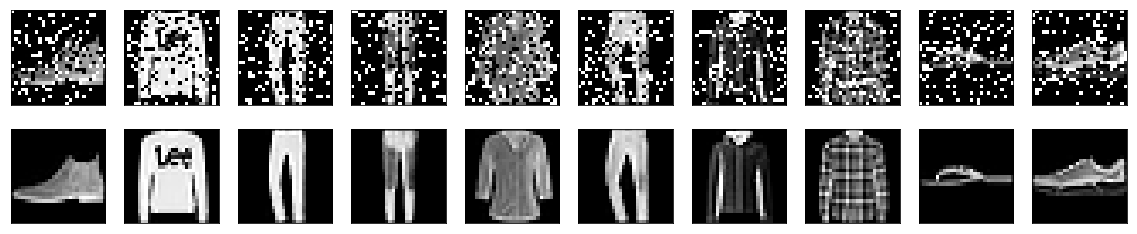

In [13]:
n=10
plt.figure(figsize = (20,4))
for i in range(n):
    # Display Original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(xtest_n[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax .get_yaxis().set_visible(False)
    
    # Display Reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(X_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [81]:
print(8./255.)

0.03137254901960784


# Adversarial Attacks

In [97]:
from scipy.misc import imsave

In [107]:
print("mnist_test_%d_%d_%d"%(12884,1,10))

mnist_test_12884_1_10


In [14]:
mnist_cnn.targeted_attack(X_test,Y_test)

NameError: name 'Xtest' is not defined

In [105]:
#adv_imgs = tf.placeholder(tf.float32,shape=(None,28,28,1))
labels_test = tf.placeholder(tf.int32,shape=(None,10))
y_te = np.argmax(Y_test,axis=1)
yte_adv = (np.argmax(Y_test,axis=1) + np.random.randint(low=1,high=9,size = (Y_test.shape[0],)))%10
Y_adv = np_utils.to_categorical(yte_adv)
#logit_test,_ = cnn_model_explicit(adv_imgs,train_mode = False)
#print(logit_test)
adv_loss = tf.nn.softmax_cross_entropy_with_logits(logits=mnist_cnn.logit_eval,
                                                  labels=labels_test)
grad = tf.gradients(adv_loss,mnist_cnn.eval_imgs)
adv = np.copy(X_test).astype('float32')
eps = 32./255.
max_iter = 20
alpha = 0.1
adv_list = []
for i in range(20):
    tmp = adv[i].reshape(1,28,28,1)
    #print(np.expand_dims(tmp,0).shape)
    lower = np.clip(tmp-eps,0,1)
    upper = np.clip(tmp+eps,0,1)
    
    for iter in range(max_iter):
        g = mnist_cnn.sess.run(grad,{mnist_cnn.eval_imgs:tmp,labels_test:np.expand_dims(Y_adv[i],0)})
        tmp = tmp - alpha*np.sign(g[0])
        tmp = np.clip(tmp,lower,upper)
        #print(np.sum(tmp[0]-np.clip(adv[i],lower,upper)))
    adv_list.append(list(tmp[0]))
    #imsave("../data/advX_"+str(i)+'_'+str(y_te[i])+'_'+str(yte_adv[i])+".png",tmp[0])
#print(adv_list)
X_adv = np.array(adv_list)

np.save('test',X_adv)




ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/slcf/.pyenv/versions/keras36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-105-71fbe0c0be75>", line 31, in <module>
    np.save('test',X_adv)
  File "/home/slcf/.pyenv/versions/keras36/lib/python3.6/site-packages/numpy/lib/npyio.py", line 490, in save
    fid = open(file, "wb")
FileNotFoundError: [Errno 2] No such file or directory: 'test.npy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/slcf/.pyenv/versions/keras36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1828, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/slcf/.pyenv/

FileNotFoundError: [Errno 2] No such file or directory: 'test.npy'

In [95]:
adv_loss =tf.nn.softmax_cross_entropy_with_logits(logits=mnist_cnn.logit_eval,
                                                  labels=labels_test)
grad = tf.gradients(adv_loss,mnist_cnn.eval_imgs)

In [96]:
print(grad)

[<tf.Tensor 'gradients_10/CLF_9/conv2d/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 28, 28, 1) dtype=float32>]


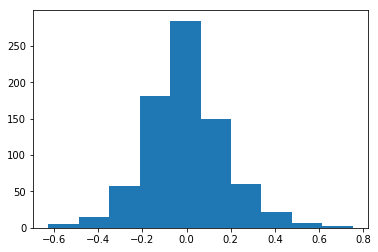

In [84]:
plt.hist(g[0].flatten())
plt.show()

In [92]:
print(mnist_cnn.accuracy_score(X_adv[:20],Y_adv[:20]))

0.8


20


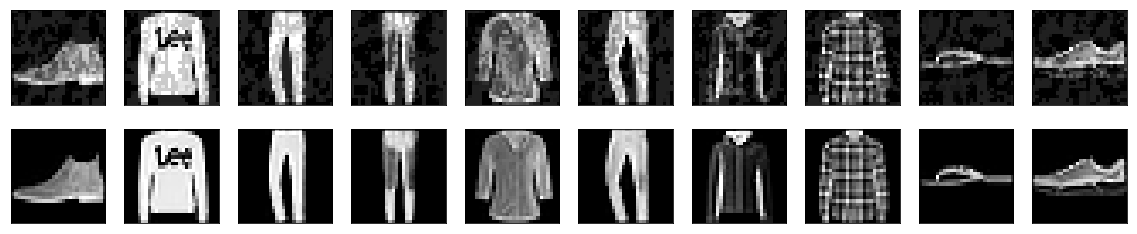

In [90]:
print(len(adv_list))

n=10
plt.figure(figsize = (20,4))
for i in range(n):
    # Display Original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(X_adv[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax .get_yaxis().set_visible(False)
    
    # Display Reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(X_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
## Try to obtain adversarial examples
grad= K.gradients(clf_model.total_loss,clf_model.input)
yte = np.argmax(Yte,axis=1)
yte_adv = (np.argmax(Yte,axis=1) + np.random.randint(low=1,high=9,size = (Yte.shape[0],)))%10

adv = np.copy(Xte)
n_test = len(yte)

for i in range(n_test):
    tmp = adv[i]
    lower = np.clip(tmp-eps,0,1)
    upper = np.clip(tmp+eps,0,1)
    
    for iter in range(10):
        g = grad.predict(tmp)